In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import numpy as np

In [2]:
# Function that creates unique id for each node

node_ids = set()

def generate_node_id(node_ids):
    new_id = random.randint(1, 1e5)
    while new_id in node_ids:
        new_id = random.randint(1, 1e5)
    node_ids.add(new_id)
    return new_id

In [3]:
# State capture per density_threshold

# By capturing the tree structure at each threshold, 
# you can see how features like connected components emerge, evolve, and disappear.
# This provides insights into the tree's resilience, adaptability, and the significance of its structural features.
# In the case of tree data structure, there is no hole so only connected dots (B_0) is considered

# Depth Threshold

depth_threshold = 3

# Degree/Density Threshold

density_thresholds = list(range(0, 4097, 16)) # [0, 16, 32, ..., 4096]

In [4]:
def build_kdtree(data, source_id, depth, density_threshold, betti_0, kdtree):
    
    # Base case
    if depth >= depth_threshold or len(data) == 0:
        return betti_0, kdtree
    
    # Randomly choose between the x-, y-, z-axis to divide the kd-tree node
    axis = random.randint(0, 2)
    data.sort(key=lambda x: x[axis])
    median = len(data) // 2

    # Increase depth
    depth += 1

    # Split data for left and right nodes of the K-D Tree
    left_data = data[:median]
    right_data = data[median:]

    for subdivision in [left_data, right_data]:
        num_points_in_box = len(subdivision)
        target_id = generate_node_id(node_ids)

        box = [num_points_in_box, depth, source_id, target_id]
        
        if num_points_in_box > density_threshold:
            kdtree.append(box)
            betti_0, kdtree = build_kdtree(subdivision, target_id, depth, density_threshold, betti_0, kdtree)
        else:
            betti_0 += 1

    return betti_0, kdtree

### $Betti_0$ Change in House Point Clouds Across K-D Tree Density Thresholds

In [5]:
# Read the data for House Random

data_random = pd.read_csv('data/House/csv/random/house_random.csv', sep=',')[['X', 'Y', 'Z']]
data_random = data_random[['X', 'Y', 'Z']].values.tolist()
house_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    house_random_betti_0s.append(betti_0)

In [6]:
# Read the data for House Spatial

data_spatial = pd.read_csv('data/House/csv/spatial/house_spatial.csv', sep=',')[['X', 'Y', 'Z']]
data_spatial = data_spatial[['X', 'Y', 'Z']].values.tolist()
house_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    house_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [7]:
var_house_random = np.var(np.array(house_random_betti_0s))
var_house_spatial = np.var(np.array(house_spatial_betti_0s))

print(var_house_random, var_house_spatial)

4.984420657390722 4.984420657390722


### Wasserstein Distance Between the Two Distributions

In [8]:
was_dis_house = wasserstein_distance(house_random_betti_0s, house_spatial_betti_0s)
print(was_dis_house)

0.0


### $Betti_0$ Change in Tree Point Clouds Across K-D Tree Density Thresholds

In [9]:
# Read the data for Tree Random

data_random = pd.read_csv('data/Tree/csv/random/tree_random.csv', sep=',')[['X', 'Y', 'Z']]
data_random = data_random[['X', 'Y', 'Z']].values.tolist()
tree_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    tree_random_betti_0s.append(betti_0)

In [10]:
# Read the data for Tree Spatial

data_spatial = pd.read_csv('data/Tree/csv/spatial/tree_spatial.csv', sep=',')[['X', 'Y', 'Z']]
data_spatial = data_spatial[['X', 'Y', 'Z']].values.tolist()
tree_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    tree_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [11]:
var_tree_random = np.var(np.array(tree_random_betti_0s))
var_tree_spatial = np.var(np.array(tree_spatial_betti_0s))

print(var_tree_random, var_tree_spatial)

4.984420657390722 4.984420657390722


### Wasserstein Distance Between the Two Distributions

In [12]:
was_dis_tree = wasserstein_distance(tree_random_betti_0s, tree_spatial_betti_0s)
print(was_dis_tree)

0.0


### $Betti_0$ Change in Light Pole Point Clouds Across K-D Tree Density Thresholds

In [13]:
# Read the data for Light Pole Random

data_random = pd.read_csv('data/LightPole/csv/random/lightpole_random.csv', sep=',')[['X', 'Y', 'Z']]
data_random = data_random[['X', 'Y', 'Z']].values.tolist()
lightpole_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    lightpole_random_betti_0s.append(betti_0)

In [14]:
# Read the data for Light Pole Spatial

data_spatial = pd.read_csv('data/LightPole/csv/spatial/lightpole_spatial.csv', sep=',')[['X', 'Y', 'Z']]
data_spatial = data_spatial[['X', 'Y', 'Z']].values.tolist()
lightpole_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    lightpole_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [15]:
var_lightpole_random = np.var(np.array(lightpole_random_betti_0s))
var_lightpole_spatial = np.var(np.array(lightpole_spatial_betti_0s))

print(var_lightpole_random, var_lightpole_spatial)

4.984420657390722 4.984420657390722


### Wasserstein Distance Between the Two Distributions

In [16]:
was_dis_lightpole = wasserstein_distance(lightpole_random_betti_0s, lightpole_spatial_betti_0s)
print(was_dis_lightpole)

0.0


### Visualizations of $Betti_0$ Change For All Input Data

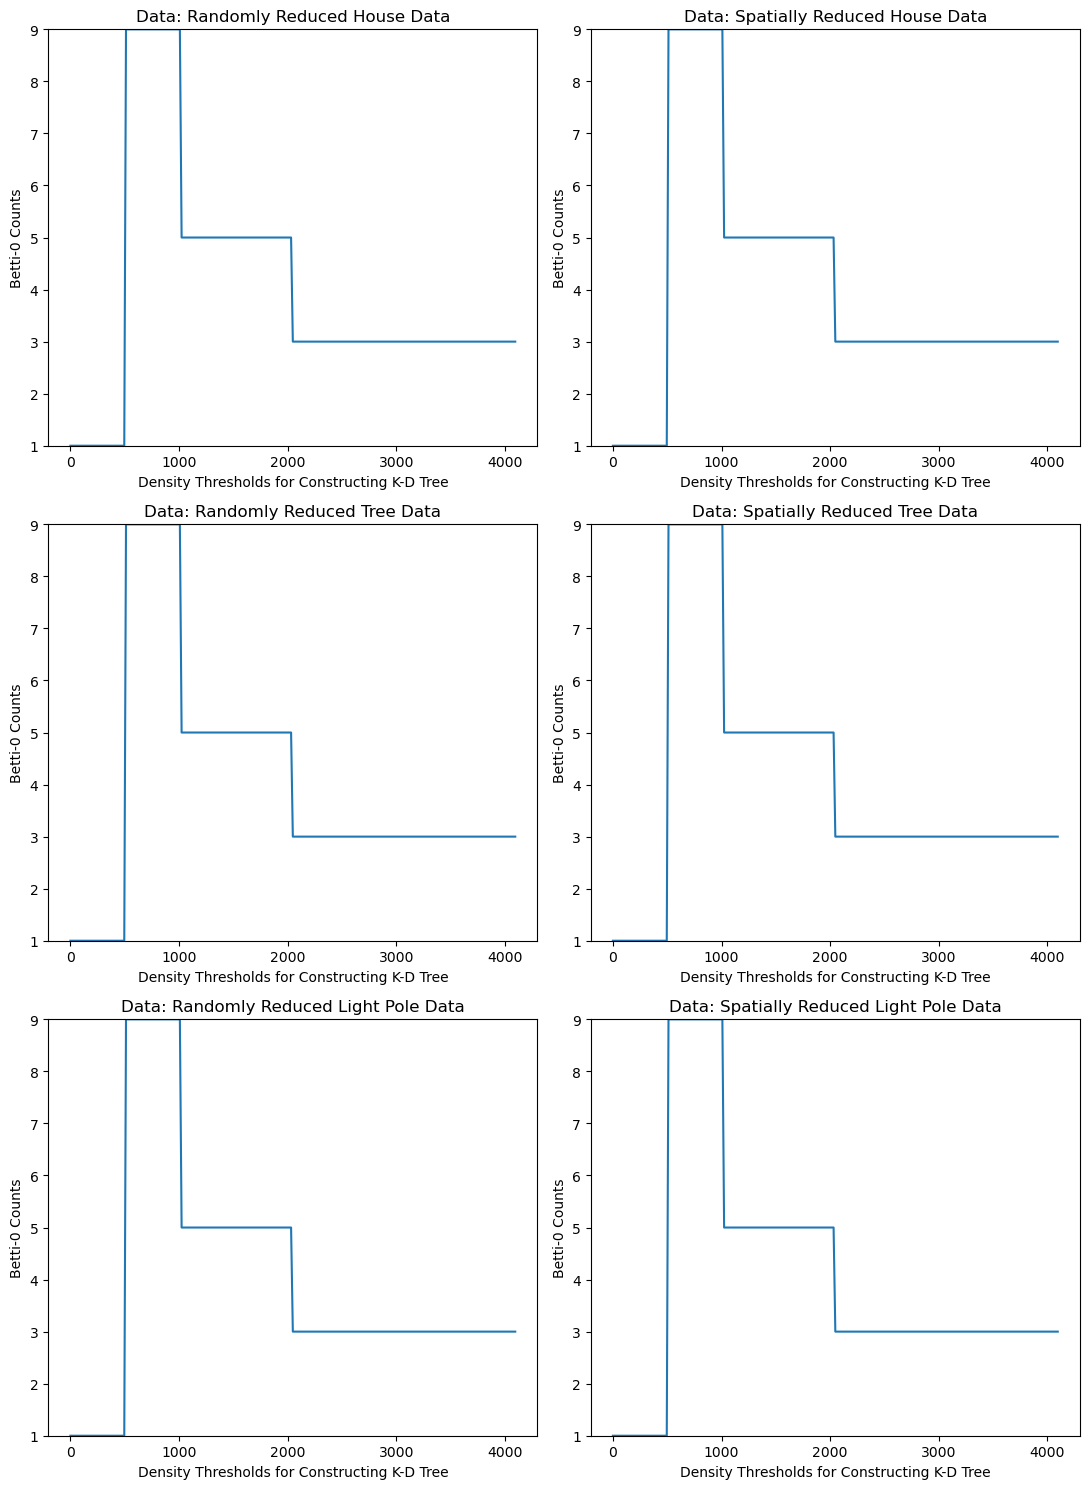

In [19]:
# Determine the global min and max y-values

min_val = min([min(house_random_betti_0s), min(house_spatial_betti_0s), \
           min(tree_random_betti_0s), min(tree_spatial_betti_0s), \
           min(lightpole_random_betti_0s), min(lightpole_random_betti_0s)])

max_val = max([max(house_random_betti_0s), max(house_spatial_betti_0s), \
           max(tree_random_betti_0s), max(tree_spatial_betti_0s), \
           max(lightpole_random_betti_0s), max(lightpole_random_betti_0s)])

# Create plot

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 15))

# Plot for House Random
axs[0,0].plot(density_thresholds, house_random_betti_0s)
axs[0,0].set_xlabel('Density Thresholds for Constructing K-D Tree')
axs[0,0].set_ylabel('Betti-0 Counts')
axs[0,0].set_ylim(min_val, max_val)
axs[0,0].set_title('Data: Randomly Reduced House Data')

# Plot for House Spatial
axs[0,1].plot(density_thresholds, house_spatial_betti_0s)
axs[0,1].set_xlabel('Density Thresholds for Constructing K-D Tree')
axs[0,1].set_ylabel('Betti-0 Counts')
axs[0,1].set_ylim(min_val, max_val)
axs[0,1].set_title('Data: Spatially Reduced House Data')

# Plot for Tree Random
axs[1,0].plot(density_thresholds, tree_random_betti_0s)
axs[1,0].set_xlabel('Density Thresholds for Constructing K-D Tree')
axs[1,0].set_ylabel('Betti-0 Counts')
axs[1,0].set_ylim(min_val, max_val)
axs[1,0].set_title('Data: Randomly Reduced Tree Data')

# Plot for Tree Spatial
axs[1,1].plot(density_thresholds, tree_spatial_betti_0s)
axs[1,1].set_xlabel('Density Thresholds for Constructing K-D Tree')
axs[1,1].set_ylabel('Betti-0 Counts')
axs[1,1].set_ylim(min_val, max_val)
axs[1,1].set_title('Data: Spatially Reduced Tree Data')

# Plot for Light Pole Random
axs[2,0].plot(density_thresholds, lightpole_random_betti_0s)
axs[2,0].set_xlabel('Density Thresholds for Constructing K-D Tree')
axs[2,0].set_ylabel('Betti-0 Counts')
axs[2,0].set_ylim(min_val, max_val)
axs[2,0].set_title('Data: Randomly Reduced Light Pole Data')

# Plot for Light Pole Spatial
axs[2,1].plot(density_thresholds, lightpole_spatial_betti_0s)
axs[2,1].set_xlabel('Density Thresholds for Constructing K-D Tree')
axs[2,1].set_ylabel('Betti-0 Counts')
axs[2,1].set_ylim(min_val, max_val)
axs[2,1].set_title('Data: Spatially Reduced Light Pole Data')

plt.tight_layout()
plt.show()

### Export Files for Visualization in Gephi

In [18]:
# kdtree_df = pd.DataFrame(kdtree, columns=['Degree', 'Depth', 'Source', 'Target'])

# # Edge
# # Source,Target,Type

# kdtree_df_edge = kdtree_df[['Source', 'Target']].copy()
# kdtree_df_edge['Type'] = 'Directed'

# # Node
# # Id,Degree(num_point),Depth

# kdtree_df_node = kdtree_df[['Target', 'Degree', 'Depth']]
# kdtree_df_node = kdtree_df_node.rename(columns={'Target': 'Id'})
# kdtree_df_node.loc[len(kdtree_df_node)] = {'Id': 0, 'Degree': 4096, 'Depth': 0} # append root node

# # export CSV

# kdtree_df_edge.to_csv('edge.csv', index = False)
# kdtree_df_node.to_csv('node.csv', index = False)